In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from models import U_Net

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device="cpu"
print(device)

cpu


In [3]:
batch_size = 128
input_shape = (batch_size, 1, 28, 28)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)
#train_dataset_init = train_dataset.data[train_dataset.targets == 8][:1800].reshape((1800, 28 * 28)).to(device)
train_dataset_target = train_dataset.data[train_dataset.targets == 1][:1800].reshape((1800, 28 * 28)).to(device)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)
test_dataset_init = test_dataset.data[test_dataset.targets == 8][:970].reshape((970, 28 * 28)).to(device)
test_dataset_target = test_dataset.data[test_dataset.targets == 1][:970].reshape((970, 1, 28, 28)).to(device)

In [4]:
torch.arange(1, 0, -0.1)

tensor([1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000,
        0.1000])

In [5]:
print(torch.max(train_dataset.data))

tensor(255, dtype=torch.uint8)


In [6]:
tens = torch.normal(torch.tensor(np.ones((1800, 28 * 28)) * 0.5), 1.0).float()
tens = tens + torch.abs(torch.min(tens))
train_dataset_init = (255 * tens / torch.abs(torch.max(tens))).to(device)
#plt.imshow(tens[0].detach().cpu().numpy(), cmap="gray")

In [7]:
# class v_model(Module):
#     def __init__(self, input_shape):
#         super().__init__()
#         self.input_shape = input_shape

#         self.NN = U_Net(input_shape=input_shape, output_channels=1, initial_lr=0.01, momentum=0.9, weight_decay=0.)

#     def forward(self, x_input, t):
#         #inputs = torch.cat([x_input, t], dim=1)
#         print(x_input[:, :1, :1].shape, t.shape)
#         inputs = x_input
#         inputs[:, :1, :1] = t
#         #inputs = torch.transpose(inputs, 0, 1)
#         x = self.NN(inputs)

#         return x

class v_model(Module):
    def __init__(self, input_dim, hidden_num):
        super().__init__()
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True),
                            Tanh(),
                            Linear(hidden_num, hidden_num, bias=True)
                            )
    
    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [8]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory

In [9]:
def train_rectified_flow(rectified_flow, optimizer, pairs, batchsize, inner_iters):
    loss_curve = []
    for i in range(inner_iters + 1):
        optimizer.zero_grad()
        indeces = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indeces]
        z0 = batch[:, 0]
        z1 = batch[:, 1]
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)

        pred = rectified_flow.v_model(z_t, t)
        loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    return rectified_flow, loss_curve

In [10]:
inner_iters = 10000
input_dim = 784
v_mod = v_model(input_dim, 784)
rectified_flow_1 = RectifiedFlow(v_mod)
pairs_1 = torch.stack([train_dataset_init, train_dataset_target], axis=1)

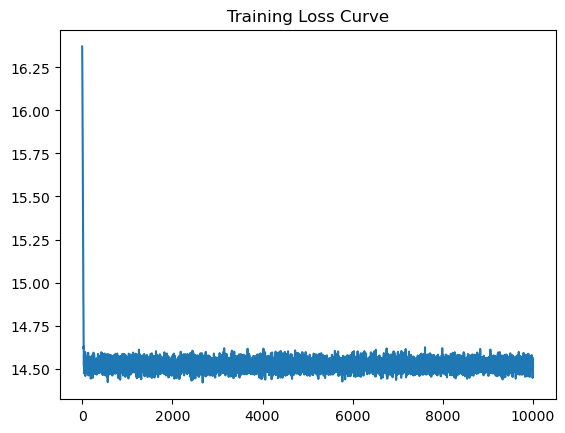

In [11]:
optimizer = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-3)

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, pairs_1, batch_size, inner_iters)
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

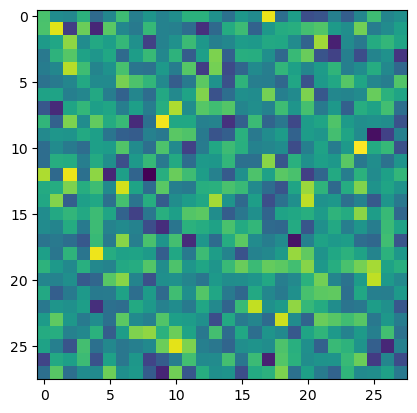

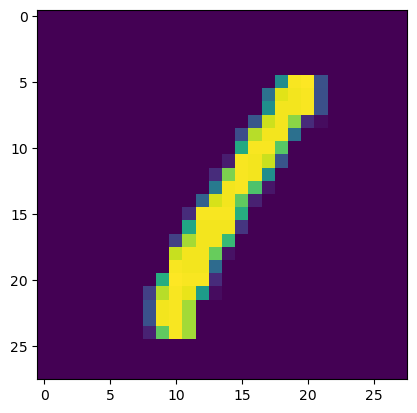

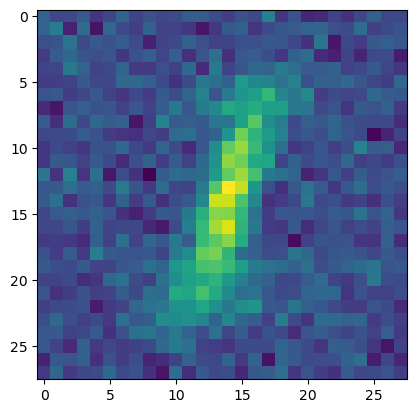

In [19]:
curr_img = 0
img = rectified_flow_1.sample_ode(pairs_1[:100][0], 100)
plt.imshow(pairs_1[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_1[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()

In [13]:
v_mod_2 = v_model(input_dim, 784)
rectified_flow_2 = RectifiedFlow(v_mod_2)
flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 100)
pairs_2 = torch.stack([train_dataset_init, flow_1[:][-1]], axis=1)

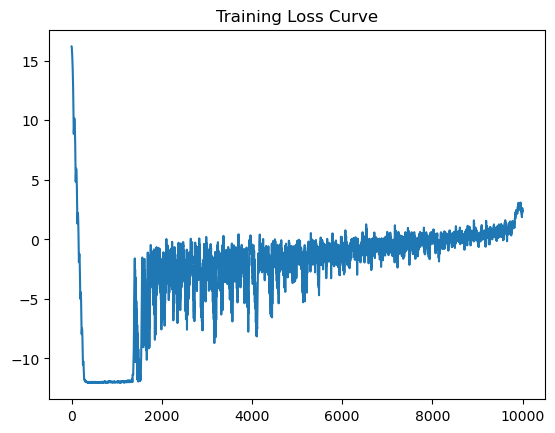

In [14]:
optimizer = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer, pairs_2, batch_size, inner_iters)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

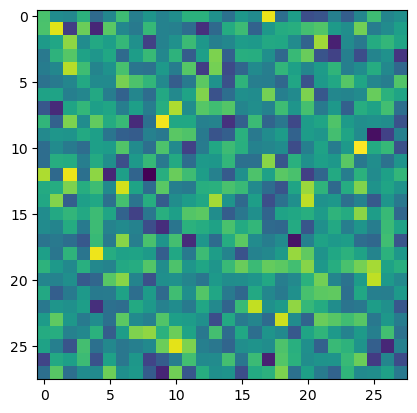

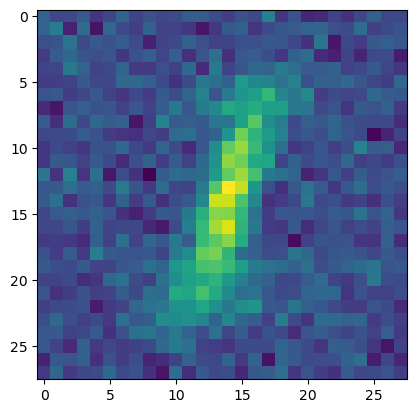

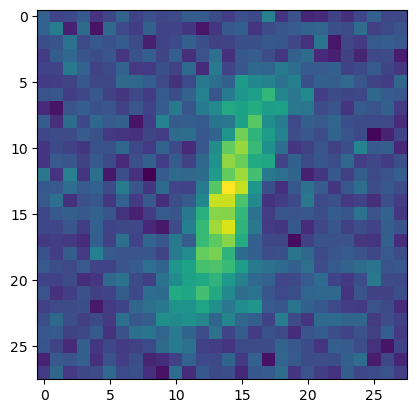

In [15]:
curr_img = 0
img = rectified_flow_2.sample_ode(pairs_1[:100][0], 100)
plt.imshow(pairs_2[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_2[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()

In [16]:
del v_mod
torch.cuda.empty_cache()
v_mod_3 = v_model(input_dim, 784)
rectified_flow_3 = RectifiedFlow(v_mod_3)
flow_2 = rectified_flow_2.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[:][-1]], axis=1)

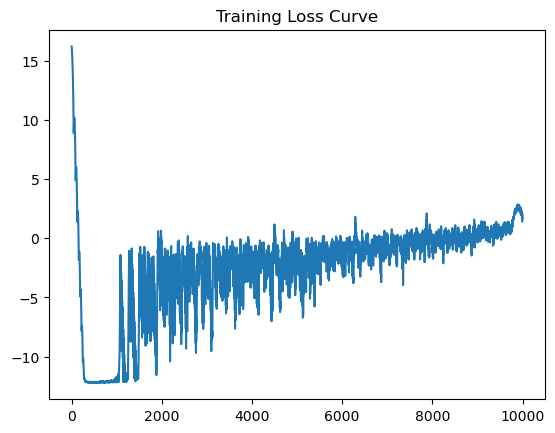

In [17]:
optimizer = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-3)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer, pairs_3, batch_size, inner_iters)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

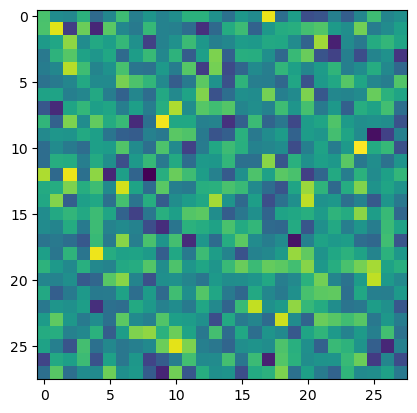

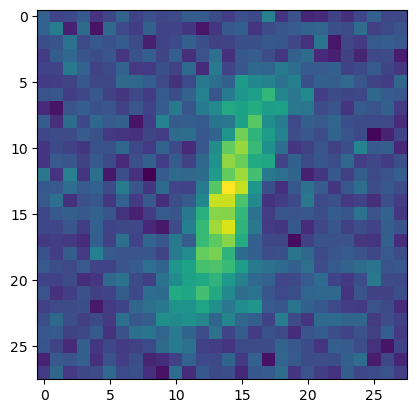

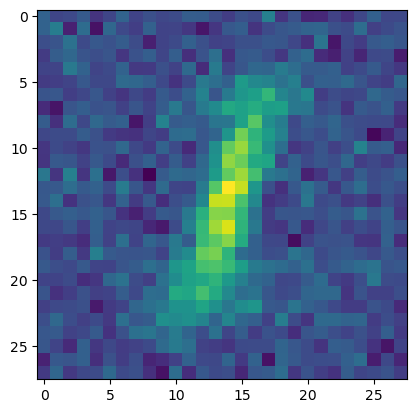

In [18]:
curr_img = 0
img = rectified_flow_3.sample_ode(pairs_1[:100][0], 100)
plt.imshow(pairs_3[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_3[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()